Epoch 0, Loss: 0.06571194529533386
Epoch 100, Loss: 0.00017808112897910178
Epoch 200, Loss: 0.00015342993719968945
Epoch 300, Loss: 0.00015117273142095655
Epoch 400, Loss: 0.00013099257193971425
Epoch 500, Loss: 0.0001254736998816952
Epoch 600, Loss: 0.00012067874922649935
Epoch 700, Loss: 0.00012014160893158987
Epoch 800, Loss: 0.00012344644346740097
Epoch 900, Loss: 0.00011613991955528036
Epoch 1000, Loss: 0.0001142294131568633
Epoch 1100, Loss: 0.0001162432090495713
Epoch 1200, Loss: 0.00010911085701081902
Epoch 1300, Loss: 0.00011266543151577935
Epoch 1400, Loss: 0.00011465583520475775
Epoch 1500, Loss: 0.00010307103366358206
Epoch 1600, Loss: 0.00011097975220764056
Epoch 1700, Loss: 0.00010469903645571321
Epoch 1800, Loss: 0.00010820918396348134
Epoch 1900, Loss: 0.0001043254160322249
Epoch 2000, Loss: 0.00010810479579959065
Epoch 2100, Loss: 0.00011001699749613181
Epoch 2200, Loss: 0.0001036031317198649
Epoch 2300, Loss: 0.00010829058737726882
Epoch 2400, Loss: 0.0001104210896301

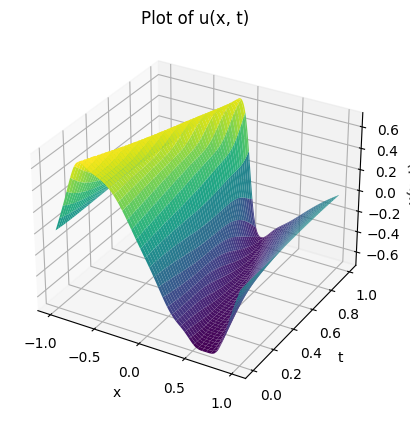

u_pred_shape: (100, 256)


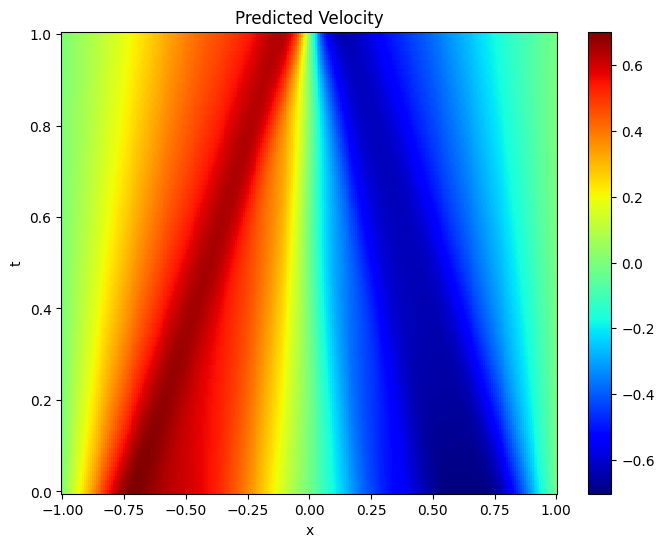

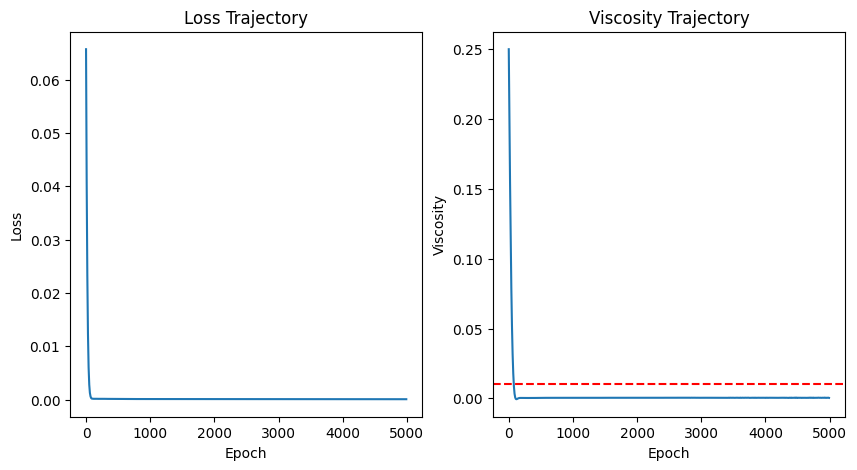

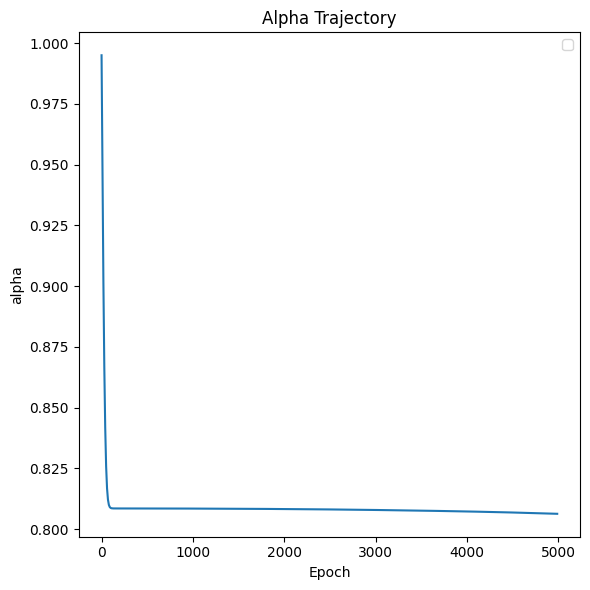

learned nu: <bound method BaseResourceVariable.numpy of <tf.Variable 'artificial_viscosity:0' shape=() dtype=float32, numpy=0.0004922574>>
alpha: <tf.Variable 'nu_loss_coefficient:0' shape=() dtype=float32, numpy=0.80631816>
batch sizes: [1024, 1024, 1024]
Variables 't_shock' and 'std_dev' are not applicable in this AV method.


In [13]:
# v?? 16 Oct 2023 

# nu / np.pi yes
# batch_size [1024, 1024, 1024]
# lr = 0.005
# learned_nu at around 0.0001
# learnabe alpha

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata

# data = scipy.io.loadmat('burgers_shock.mat')
# Exact = data['usol']
# Exact_u = np.real(Exact)

# class DomainND:
#     def __init__(self, var, time_var=None):
#         self.vars = var
#         self.domaindict = []
#         self.domain_ids = []
#         self.time_var = time_var

#     # def generate_collocation_points(self, N_f):
#     #     range_list = [
#     #         [val for key, val in dict_.items() if "range" in key][0]
#     #         for dict_ in self.domaindict
#     #     ]

#     #     limits = np.array(range_list)  # x,t domain
#     #     X_f = LatinHypercubeSample(N_f, limits)
#     #     self.X_f = X_f

#     def add(self, token, vals, fidel):
#         self.domain_ids.append(token)
#         self.domaindict.append({
#             "identifier": token,
#             "range": vals,
#             (token + "fidelity"): fidel,
#             (token + "linspace"): np.linspace(vals[0], vals[1], fidel),
#             (token + "upper"): vals[1],
#             (token + "lower"): vals[0]
#         })
        
# DomainND = DomainND(["x", "t"], time_var='t')

# DomainND.add("x", [-1.0, 1.0], 256)
# DomainND.add("t", [0.0, 1.0], 100)

# Define the domain class

class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v, batch_size):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.batch_size_r = batch_size[0]
        self.batch_size_0 = batch_size[1]
        self.batch_size_b = batch_size[2]
        self.viscosity = tf.Variable(initial_value=viscosity_init_v, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="artificial_viscosity")
        self.alpha = tf.Variable(initial_value=1,
                                 trainable=True,
                                 dtype=tf.float32,
                                 name="nu_loss_coefficient")
    
# Define the initial condition
def initial_condition(domain, x):
    # initial_output = np.where(x > 0, 1, 0)
    initial_output = -np.sin(np.pi * x)
    return initial_output 

# Define the boundary conditions
def boundary_conditions(domain, x, t):
    return np.zeros_like(x)

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, t, batch_size):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        
        u = network(tf.concat([x, t], axis=1))

        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType
        u_xx = tape.gradient(u_x, x)

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")

        # Define the Burgers equation residual
        residual = u_t + u * u_x - domain.viscosity / np.pi * u_xx
    
    # Define the boundary and initial condition residuals # Done_TODO check "u" LR
    # Compute the loss for initial condition
    num_batch_size_0 = domain.batch_size_0
    t_batch_0 = tf.fill([num_batch_size_0, 1], 0.001) # considered as 0
    x_batch_0 = tf.random.uniform([num_batch_size_0, 1], minval=domain.x_min, maxval=domain.x_max)
    u_0 = network(tf.concat([x_batch_0, t_batch_0], axis=1))
    initial_residual = u_0 - initial_condition(domain, x_batch_0)

    # Compute the loss for boundary condition
    num_batch_size_b = domain.batch_size_b
    x_batch_bl = tf.cast(tf.fill([num_batch_size_b, 1], -1), dtype=tf.float32)
    x_batch_br = tf.cast(tf.fill([num_batch_size_b, 1], 1), dtype=tf.float32)
    t_batch_b  = tf.random.uniform([num_batch_size_b, 1], minval=domain.t_min, maxval=domain.t_max)
    u_bl = network(tf.concat([x_batch_bl, t_batch_b], axis=1)) # int32 and float incompatible
    u_br = network(tf.concat([x_batch_br, t_batch_b], axis=1))
    lower_boundary_residual = u_bl - boundary_conditions(domain, x_batch_bl, t_batch_b)
    upper_boundary_residual = u_br - boundary_conditions(domain, x_batch_br, t_batch_b)

    viscosity_loss = tf.square(domain.viscosity) 

    loss = tf.reduce_mean(tf.square(residual)) / batch_size + \
           tf.reduce_mean(tf.square(initial_residual)) / num_batch_size_0 + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) / num_batch_size_b + \
           tf.reduce_mean(tf.square(upper_boundary_residual)) / num_batch_size_b + \
            domain.alpha * viscosity_loss
    
    return loss

# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Lists to store loss and viscosity values for each epoch
    history = [[] for _ in range(3)]  # Initialize history as a list with three empty lists
    # history components, [0]: loss, [1]: nu, [2]: alpha

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.t_min, maxval=domain.t_max)

        with tf.GradientTape() as tape:
            loss = physics_informed_loss(network, domain, x_batch, t_batch, domain.batch_size_r)

        # add viscosity into the trainable variables from TF
        variable_list = network.trainable_variables + [domain.viscosity] + [domain.alpha]

        gradients = tape.gradient(loss, variable_list)
        # # Update αvisc based on negative gradient
        # alpha_update = -learning_rate * gradients[-1]  # Negative gradient ascent
        # domain.alpha.assign_add(alpha_update)

        # # Apply gradients to the network weights
        # # optimizer.apply_gradients(zip(gradients[:-2], variable_list[:-2]))
        optimizer.apply_gradients(zip(gradients, variable_list))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

        if epoch % 10 == 0:
            # Append the loss and viscosity values to the history lists
            history[0].append(loss.numpy())
            history[1].append(domain.viscosity.numpy())
            history[2].append(domain.alpha.numpy())
    
    return network, history 

# Visualize the results
def visualize_results(model, domain, history, num_epochs):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    X = np.hstack((x_grid.flatten()[:, tf.newaxis], t_grid.flatten()[:, tf.newaxis]))
    u_pred_grid = model.predict(X)
    u_pred_grid = griddata(X, u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(x_grid, t_grid, u_pred_grid, cmap='viridis')

    # Set labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x, t)')
    plt.title('Plot of u(x, t)')
    plt.show()

    print("u_pred_shape:", u_pred_grid.shape)

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

    # Define the x-axis labels at intervals of every 10 epochs
    x_labels = list(range(0, num_epochs, 10))

    # Plot the loss and viscosity trajectories
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_labels, history[0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trajectory')

    plt.subplot(1, 2, 2)
    plt.plot(x_labels, history[1])
    plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')
    plt.xlabel('Epoch')
    plt.ylabel('Viscosity')
    plt.title('Viscosity Trajectory')

    plt.figure(figsize=(6, 6))
    plt.plot(x_labels, history[2])
    plt.xlabel('Epoch')
    plt.ylabel('alpha')
    plt.title('Alpha Trajectory')

    plt.legend()
    plt.tight_layout()
    plt.show()
    return u_pred_grid


if __name__ == "__main__":
    # Define domain parameters and create the domain
    x_min = -1.0
    x_max = 1.0
    t_min = 0
    t_max = 1.00
    num_x = 256
    num_t = 100
    batch_size_r=1024
    num_batch_size_0 = 1024
    num_batch_size_b = 1024
    batch_size = [batch_size_r, num_batch_size_0, num_batch_size_b] # define batch_size list 
    viscosity_init_v = tf.random.uniform(shape=(), minval=0.001, maxval=1.0)
    domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v, batch_size)
    num_epochs = 5000

    # Create the neural network 
    network = create_network()

    # Train the model using PINNs
    model, history = train_model(network, 
                                 domain, 
                                 num_epochs,
                                 learning_rate=0.005
                                 )

    # Visualize the results
    u_pred_grid = visualize_results(model, domain, history, num_epochs)

    print("learned nu:", domain.viscosity.numpy)
    print("alpha:", domain.alpha)
    print("batch sizes:", batch_size)

    if hasattr(domain, 't_shock'):
        print("t_shock:", domain.t_shock)
        print("std_dev:", domain.std_dev)
    else:
        print("Variables 't_shock' and 'std_dev' are not applicable in this AV method.")
    # try:
    #     # Attempt to access the variable
    #     domain.t_shock
    #     print("t_shock:", domain.t_shock)
    #     print("std_dev:", domain.std_dev)
    # except NameError:
    #     print("Variables 't_shock' and 'std_dev' are not applicable in this AV method.")


exact_u shape: (256, 100)
u_star shape: (25600, 1)
u_star 2 shape: (100, 256)


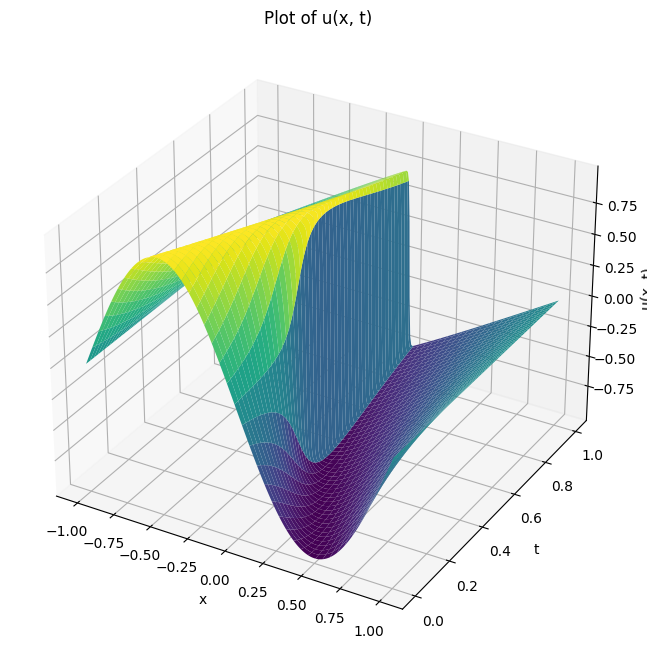

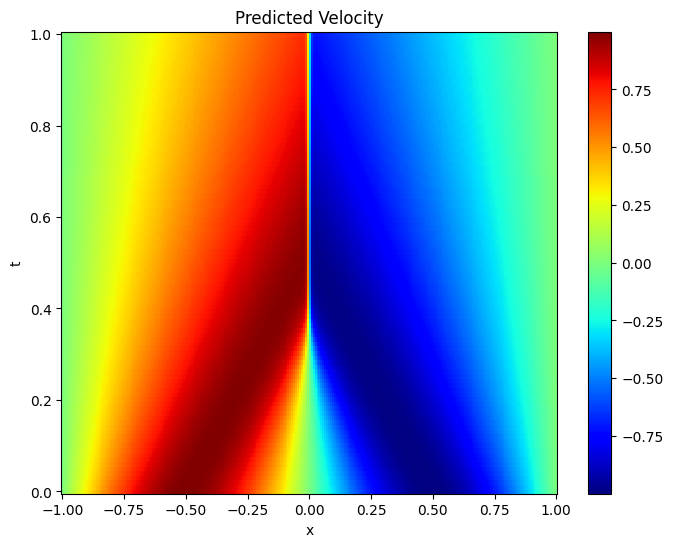

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add', 'domain_ids', 'domaindict', 'time_var', 'vars']
800/800 [==============================] - 0s 342us/step
L2 error between predicted u and actual u: 0.2772844380128698


In [23]:
import scipy
import numpy as np
import tensorflow as tf

class DomainND:
    def __init__(self, var, time_var=None):
        self.vars = var
        self.domaindict = []
        self.domain_ids = []
        self.time_var = time_var

    # def generate_collocation_points(self, N_f):
    #     range_list = [
    #         [val for key, val in dict_.items() if "range" in key][0]
    #         for dict_ in self.domaindict
    #     ]

    #     limits = np.array(range_list)  # x,t domain
    #     X_f = LatinHypercubeSample(N_f, limits)
    #     self.X_f = X_f

    def add(self, token, vals, fidel):
        self.domain_ids.append(token)
        self.domaindict.append({
            "identifier": token,
            "range": vals,
            (token + "fidelity"): fidel,
            (token + "linspace"): np.linspace(vals[0], vals[1], fidel),
            (token + "upper"): vals[1],
            (token + "lower"): vals[0]
        })
        
DomainND = DomainND(["x", "t"], time_var='t')

DomainND.add("x", [-1.0, 1.0], 256)
DomainND.add("t", [0.0, 1.0], 100)

# input data
data = scipy.io.loadmat('burgers_shock.mat')
Exact = data['usol']
Exact_u = np.real(Exact) # shape of [256, 100]
x = DomainND.domaindict[0]['xlinspace']
t = DomainND.domaindict[1]["tlinspace"]

X, T = np.meshgrid(x, t)

# print(np.shape((X,T))) #2, 100, 256
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact_u.T.flatten()[:, None] # shape of [25600, 1]
print("exact_u shape:", Exact_u.shape)
print("u_star shape:", u_star.shape)
u_star_2 = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
print("u_star 2 shape:", u_star_2.shape)

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, T, u_star_2, cmap='viridis')
# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x, t)')
plt.title('Plot of u(x, t)')
plt.show()

# 2D plotting
plt.figure(figsize=(8, 6))
plt.pcolor(X, T, u_star_2, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted Velocity')
plt.show()

print(dir(DomainND))

u_pred_grid = model.predict(X_star)

l2_error = tf.sqrt(tf.reduce_mean(tf.square(u_pred_grid - u_star)))
print("L2 error between predicted u and actual u:", l2_error.numpy())

